In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import ngboost as ngb
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
# Evaluation Metrics
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score, y_true):
    mean = y_true.mean()
    return (score/mean) * 100

def mae(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def test_rmse(y_true, y_pred):
    print(f"mae : {mae(y_true, y_pred)}")
    print(f"RMSE : {evaluation_metric(y_true, y_pred)}")
    print(f"Normalized RMSE : {nrmse(y_true, y_pred)}")
    score = evaluation_metric(y_true, y_pred)
    print(f"Error Percentage : {test_error_percentage(score, y_true)}")
    
def preprocess_data(test_num):
    
    all_data = pd.read_csv('asos_train.csv', encoding='cp949')

    all_data_train = all_data[all_data['location'] != test_num]
    all_data_test = all_data[all_data['location'] == test_num]



    all_data_train.fillna(-1, inplace=True)
    all_data_test.fillna(-1, inplace=True)

    all_data = pd.concat([all_data_train, all_data_test], ignore_index=True)

    all_data['date'] = pd.to_datetime(all_data['date'])

    # 연도, 월, 시간 추출하여 새로운 열로 추가
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['hour'] = all_data['date'].dt.hour

# Index(['power', 'date', 'name', 'capacities', 'asos_num', 'land', 'power/land',
#        'location', 'Date/Time', 'Temp(C)', 'Prec(mm)', 'Wind_speed(m/s)',
#        'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)',
#        'Dew_Point(C)', 'Local Atmospheric Pressure(hPa)',
#        'Sea-level_Pressure(hPa)', 'sunshine(hr)', 'Solar_Radiation(MJ/m2)',
#        'Snowfall(cm)', '3-hour_Fresh_Snowfall', 'Cloud_Cover(1/10)',
#        'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
#        'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
#        'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
#        '20cm_Underground_Temp', '30cm_Underground_Temp'],
#       dtype='object')

    drop_columns = ["date", "asos_num", "location", "name", "power/land", "power", "capacities", "land",
                   'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)', "Date/Time",
                    'Local Atmospheric Pressure(hPa)',
                   'Sea-level_Pressure(hPa)', 
                   '3-hour_Fresh_Snowfall',
                   'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
                   'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
                   'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
                   '20cm_Underground_Temp', '30cm_Underground_Temp']

    all_data = all_data.drop(columns=drop_columns)

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
    num_train = len(all_data_train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = all_data_train['power/land'].values
    y_test = all_data_test['power/land'].values
    return X, y, X_test, y_test

def calculate_pearsonr(data1, data2):
    return pearsonr(data1, data2)

def daily_visualize(y_test_array, preds, test_df):
    # 'date' 칼럼을 datetime 형식으로 변환하고 인덱스로 설정
    y_test_df = pd.DataFrame(y_test_array, index=pd.to_datetime(test_df['date']), columns=['power/land'])
    
    # 일자별로 그룹화하고 합계를 계산
    daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power/land'].sum().values
    daily_predicted_sum = [np.sum(preds[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]
    
    # 상관계수 계산
    corr_coefficient, p_value = calculate_pearsonr(daily_actual_sum, daily_predicted_sum)

    plt.figure(figsize=(15, 6))
    plt.plot(daily_actual_sum, label='Actual Daily Power Sum', color='blue')
    plt.plot(daily_predicted_sum, label='Predicted Daily Power Sum', color='red', alpha=0.7)
    plt.title('Daily Power Sum')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')
    
    # 상관계수를 그래프 상에 주석으로 추가
    corr_text = f"Pearson correlation coefficient: {corr_coefficient:.6f}\nP-value: {p_value:.6f}"
    plt.annotate(corr_text, xy=(0.75, 0.15), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

    plt.show()

In [13]:
def main(test_nums, model_choices):
    for test_num in test_nums:
        print(f"Testing for location {test_num}...")
        
        all_data = pd.read_csv('asos_train.csv', encoding='cp949')
        all_data_train = all_data[all_data['location'] != test_num]
        all_data_test = all_data[all_data['location'] == test_num]

        X, y, X_test, y_test = preprocess_data(test_num)

        for model_choice in model_choices:
            print(f"\tTraining and Predicting using {model_choice} model...")

            if model_choice == 'lgb': #lightgbm
                model = LGBMRegressor()
            elif model_choice == 'xgb': #xgboost
                model = XGBRegressor()
            elif model_choice == 'ext': #extratree
                model = ExtraTreesRegressor()
            elif model_choice == 'rf': #random forest
                model = RandomForestRegressor()
            elif model_choice == 'cbc': #catboost
                model = CatBoostRegressor()
            elif model_choice == 'ngb': #ngboost
                model = ngb.NGBRegressor()
            # For other models, you can add more elif conditions as needed.

            model.fit(X, y)
            predictions = model.predict(X_test)
            test_rmse(y_test, predictions)
            daily_visualize(y_test, predictions, all_data_test)

            print(f"\tCompleted {model_choice} model.")
        print(f"Completed testing for location {test_num}.\n\n")

Testing for location 165.0...


C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


	Training and Predicting using lgb model...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 203914, number of used features: 11
[LightGBM] [Info] Start training from score 26.964930
mae : 10.864657361469071
RMSE : 16.614859421192303
Normalized RMSE : 0.235650007710037
Error Percentage : 71.84605512822337


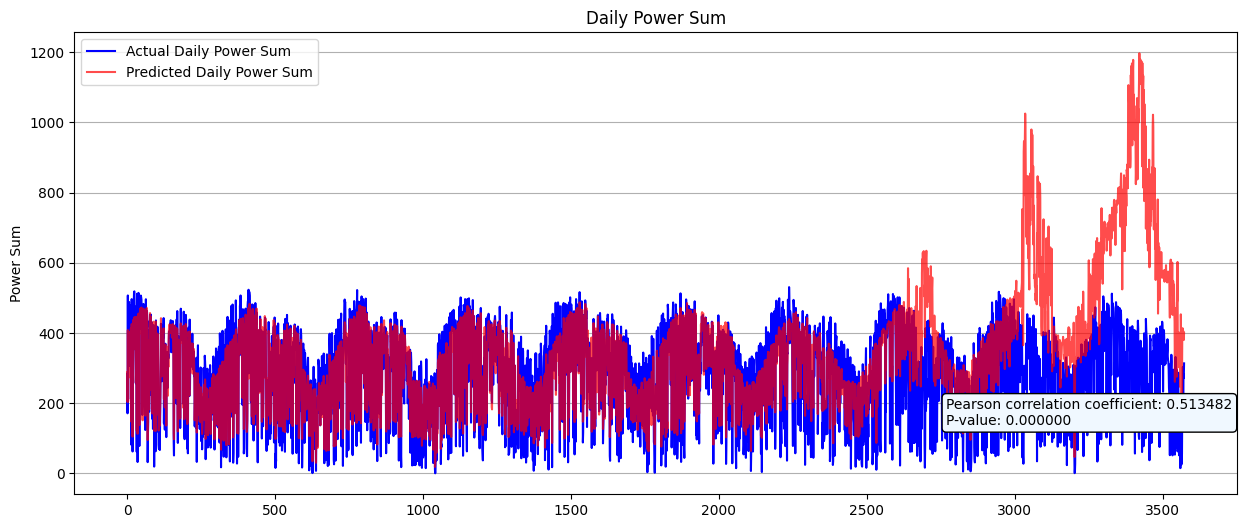

	Completed lgb model.
	Training and Predicting using xgb model...
mae : 11.848949269385685
RMSE : 18.975588948265603
Normalized RMSE : 0.2691324415455328
Error Percentage : 82.05433311874287


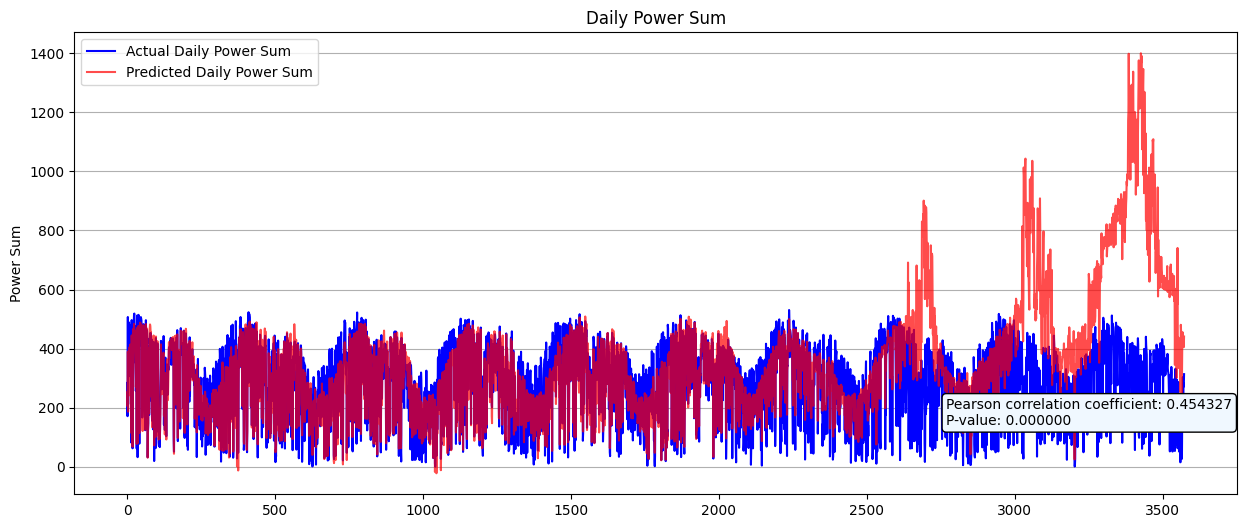

	Completed xgb model.
	Training and Predicting using ext model...
mae : 12.279991888938927
RMSE : 19.552300969167096
Normalized RMSE : 0.27731199869535517
Error Percentage : 84.54815401703756


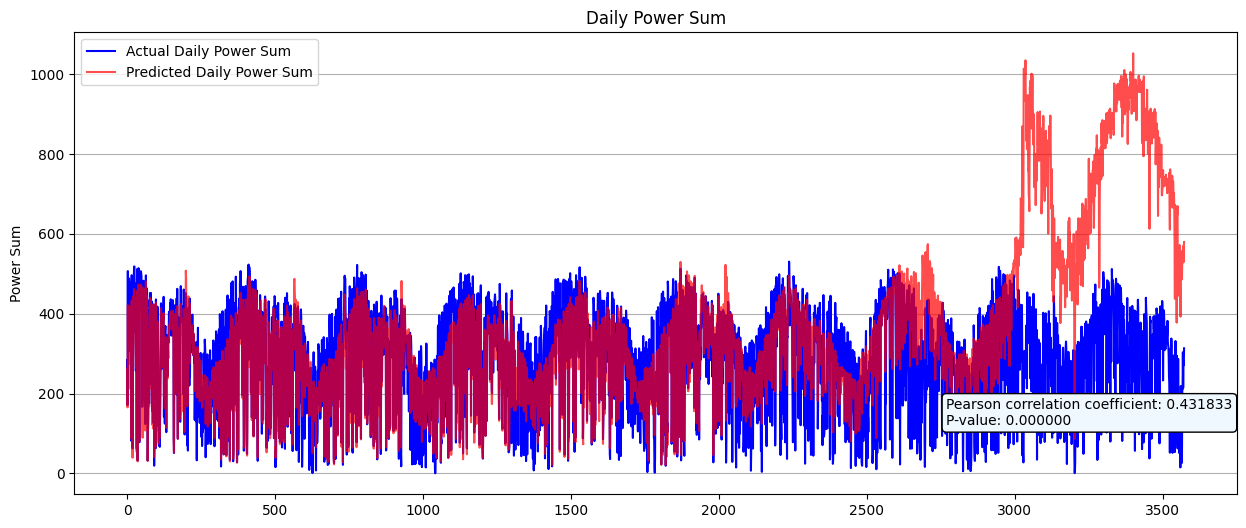

	Completed ext model.
	Training and Predicting using rf model...
mae : 12.15413115766754
RMSE : 19.510851949683257
Normalized RMSE : 0.27672412361839355
Error Percentage : 84.36891996736222


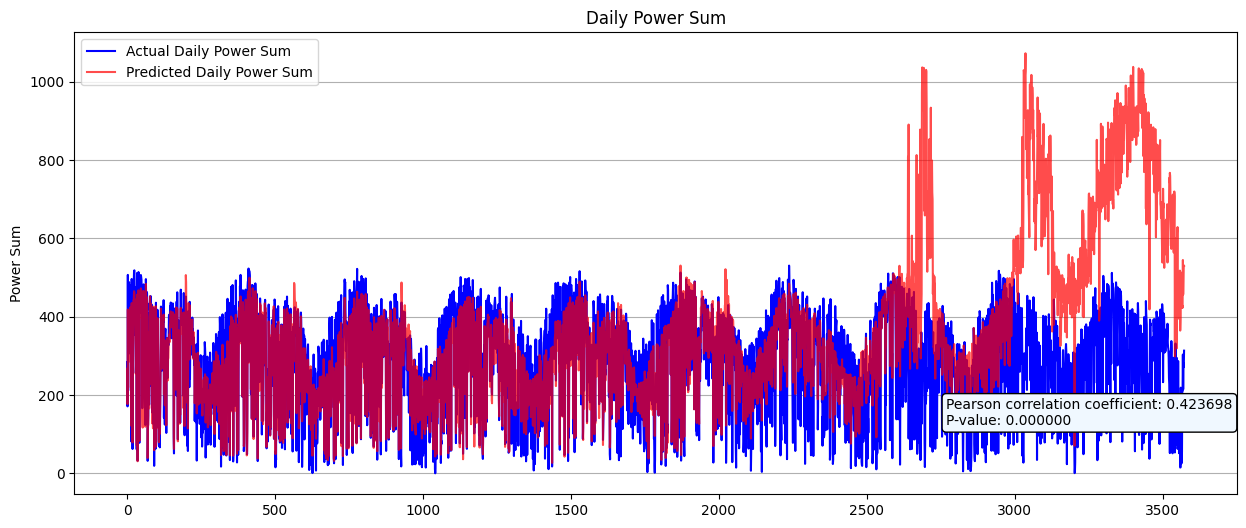

	Completed rf model.
	Training and Predicting using cbc model...
Learning rate set to 0.094858
0:	learn: 23.4772518	total: 200ms	remaining: 3m 19s
1:	learn: 23.2601716	total: 219ms	remaining: 1m 49s
2:	learn: 23.0710520	total: 234ms	remaining: 1m 17s
3:	learn: 22.9294688	total: 249ms	remaining: 1m 1s
4:	learn: 22.7924340	total: 263ms	remaining: 52.3s
5:	learn: 22.6789025	total: 279ms	remaining: 46.2s
6:	learn: 22.5655905	total: 294ms	remaining: 41.7s
7:	learn: 22.4785467	total: 308ms	remaining: 38.1s
8:	learn: 22.3996744	total: 322ms	remaining: 35.4s
9:	learn: 22.3283021	total: 335ms	remaining: 33.2s
10:	learn: 22.2721651	total: 349ms	remaining: 31.4s
11:	learn: 22.2176823	total: 363ms	remaining: 29.9s
12:	learn: 22.1734681	total: 376ms	remaining: 28.6s
13:	learn: 22.1187194	total: 390ms	remaining: 27.5s
14:	learn: 22.0699672	total: 405ms	remaining: 26.6s
15:	learn: 22.0249490	total: 424ms	remaining: 26.1s
16:	learn: 21.9905476	total: 440ms	remaining: 25.4s
17:	learn: 21.9613909	total:

161:	learn: 20.7291735	total: 2.57s	remaining: 13.3s
162:	learn: 20.7266190	total: 2.58s	remaining: 13.3s
163:	learn: 20.7232179	total: 2.6s	remaining: 13.3s
164:	learn: 20.7196444	total: 2.62s	remaining: 13.2s
165:	learn: 20.7143327	total: 2.63s	remaining: 13.2s
166:	learn: 20.7110715	total: 2.65s	remaining: 13.2s
167:	learn: 20.7087661	total: 2.66s	remaining: 13.2s
168:	learn: 20.7038187	total: 2.67s	remaining: 13.2s
169:	learn: 20.7005019	total: 2.69s	remaining: 13.1s
170:	learn: 20.6961681	total: 2.7s	remaining: 13.1s
171:	learn: 20.6922043	total: 2.72s	remaining: 13.1s
172:	learn: 20.6888154	total: 2.73s	remaining: 13.1s
173:	learn: 20.6853845	total: 2.75s	remaining: 13.1s
174:	learn: 20.6818193	total: 2.76s	remaining: 13s
175:	learn: 20.6777971	total: 2.78s	remaining: 13s
176:	learn: 20.6761299	total: 2.8s	remaining: 13s
177:	learn: 20.6731925	total: 2.81s	remaining: 13s
178:	learn: 20.6706567	total: 2.83s	remaining: 13s
179:	learn: 20.6668994	total: 2.84s	remaining: 12.9s
180:	l

319:	learn: 20.3743213	total: 4.93s	remaining: 10.5s
320:	learn: 20.3725262	total: 4.95s	remaining: 10.5s
321:	learn: 20.3712637	total: 4.97s	remaining: 10.5s
322:	learn: 20.3701637	total: 4.98s	remaining: 10.4s
323:	learn: 20.3692802	total: 5s	remaining: 10.4s
324:	learn: 20.3679521	total: 5.01s	remaining: 10.4s
325:	learn: 20.3669697	total: 5.03s	remaining: 10.4s
326:	learn: 20.3648043	total: 5.04s	remaining: 10.4s
327:	learn: 20.3629386	total: 5.06s	remaining: 10.4s
328:	learn: 20.3616378	total: 5.08s	remaining: 10.4s
329:	learn: 20.3598318	total: 5.09s	remaining: 10.3s
330:	learn: 20.3590939	total: 5.11s	remaining: 10.3s
331:	learn: 20.3580085	total: 5.12s	remaining: 10.3s
332:	learn: 20.3574051	total: 5.14s	remaining: 10.3s
333:	learn: 20.3563914	total: 5.15s	remaining: 10.3s
334:	learn: 20.3548669	total: 5.17s	remaining: 10.3s
335:	learn: 20.3540344	total: 5.19s	remaining: 10.3s
336:	learn: 20.3526050	total: 5.2s	remaining: 10.2s
337:	learn: 20.3521367	total: 5.22s	remaining: 10.

483:	learn: 20.1613240	total: 7.7s	remaining: 8.21s
484:	learn: 20.1602430	total: 7.72s	remaining: 8.2s
485:	learn: 20.1590739	total: 7.74s	remaining: 8.19s
486:	learn: 20.1577142	total: 7.76s	remaining: 8.18s
487:	learn: 20.1570154	total: 7.78s	remaining: 8.16s
488:	learn: 20.1557676	total: 7.79s	remaining: 8.14s
489:	learn: 20.1548432	total: 7.81s	remaining: 8.13s
490:	learn: 20.1539967	total: 7.82s	remaining: 8.11s
491:	learn: 20.1533199	total: 7.84s	remaining: 8.09s
492:	learn: 20.1521201	total: 7.86s	remaining: 8.08s
493:	learn: 20.1514729	total: 7.87s	remaining: 8.06s
494:	learn: 20.1501047	total: 7.89s	remaining: 8.05s
495:	learn: 20.1488696	total: 7.9s	remaining: 8.03s
496:	learn: 20.1479584	total: 7.92s	remaining: 8.02s
497:	learn: 20.1463077	total: 7.94s	remaining: 8s
498:	learn: 20.1457076	total: 7.96s	remaining: 7.99s
499:	learn: 20.1444125	total: 7.97s	remaining: 7.97s
500:	learn: 20.1434502	total: 7.99s	remaining: 7.96s
501:	learn: 20.1416777	total: 8.01s	remaining: 7.94s

647:	learn: 19.9962529	total: 10.5s	remaining: 5.68s
648:	learn: 19.9946340	total: 10.5s	remaining: 5.67s
649:	learn: 19.9937600	total: 10.5s	remaining: 5.66s
650:	learn: 19.9929379	total: 10.5s	remaining: 5.64s
651:	learn: 19.9916113	total: 10.5s	remaining: 5.62s
652:	learn: 19.9907287	total: 10.6s	remaining: 5.61s
653:	learn: 19.9901101	total: 10.6s	remaining: 5.59s
654:	learn: 19.9897531	total: 10.6s	remaining: 5.57s
655:	learn: 19.9888250	total: 10.6s	remaining: 5.56s
656:	learn: 19.9883268	total: 10.6s	remaining: 5.54s
657:	learn: 19.9875118	total: 10.6s	remaining: 5.53s
658:	learn: 19.9869458	total: 10.6s	remaining: 5.51s
659:	learn: 19.9862564	total: 10.7s	remaining: 5.49s
660:	learn: 19.9851700	total: 10.7s	remaining: 5.48s
661:	learn: 19.9839901	total: 10.7s	remaining: 5.46s
662:	learn: 19.9830894	total: 10.7s	remaining: 5.45s
663:	learn: 19.9826315	total: 10.7s	remaining: 5.43s
664:	learn: 19.9812986	total: 10.8s	remaining: 5.42s
665:	learn: 19.9804434	total: 10.8s	remaining:

813:	learn: 19.8765161	total: 13.2s	remaining: 3.02s
814:	learn: 19.8760064	total: 13.3s	remaining: 3.01s
815:	learn: 19.8756234	total: 13.3s	remaining: 2.99s
816:	learn: 19.8749928	total: 13.3s	remaining: 2.98s
817:	learn: 19.8746869	total: 13.3s	remaining: 2.96s
818:	learn: 19.8734045	total: 13.3s	remaining: 2.94s
819:	learn: 19.8725494	total: 13.3s	remaining: 2.93s
820:	learn: 19.8719832	total: 13.4s	remaining: 2.91s
821:	learn: 19.8714003	total: 13.4s	remaining: 2.9s
822:	learn: 19.8702698	total: 13.4s	remaining: 2.88s
823:	learn: 19.8694857	total: 13.4s	remaining: 2.86s
824:	learn: 19.8686181	total: 13.4s	remaining: 2.85s
825:	learn: 19.8680648	total: 13.4s	remaining: 2.83s
826:	learn: 19.8674285	total: 13.5s	remaining: 2.81s
827:	learn: 19.8670669	total: 13.5s	remaining: 2.8s
828:	learn: 19.8661993	total: 13.5s	remaining: 2.78s
829:	learn: 19.8653266	total: 13.5s	remaining: 2.77s
830:	learn: 19.8649216	total: 13.5s	remaining: 2.75s
831:	learn: 19.8641785	total: 13.5s	remaining: 2

978:	learn: 19.7687963	total: 16s	remaining: 343ms
979:	learn: 19.7680553	total: 16s	remaining: 327ms
980:	learn: 19.7671694	total: 16s	remaining: 310ms
981:	learn: 19.7664378	total: 16s	remaining: 294ms
982:	learn: 19.7658125	total: 16.1s	remaining: 278ms
983:	learn: 19.7651741	total: 16.1s	remaining: 261ms
984:	learn: 19.7649851	total: 16.1s	remaining: 245ms
985:	learn: 19.7646723	total: 16.1s	remaining: 229ms
986:	learn: 19.7643278	total: 16.1s	remaining: 212ms
987:	learn: 19.7635389	total: 16.1s	remaining: 196ms
988:	learn: 19.7629369	total: 16.2s	remaining: 180ms
989:	learn: 19.7619721	total: 16.2s	remaining: 163ms
990:	learn: 19.7615463	total: 16.2s	remaining: 147ms
991:	learn: 19.7613363	total: 16.2s	remaining: 131ms
992:	learn: 19.7609758	total: 16.2s	remaining: 114ms
993:	learn: 19.7605784	total: 16.3s	remaining: 98.1ms
994:	learn: 19.7603518	total: 16.3s	remaining: 81.7ms
995:	learn: 19.7599490	total: 16.3s	remaining: 65.4ms
996:	learn: 19.7598090	total: 16.3s	remaining: 49ms

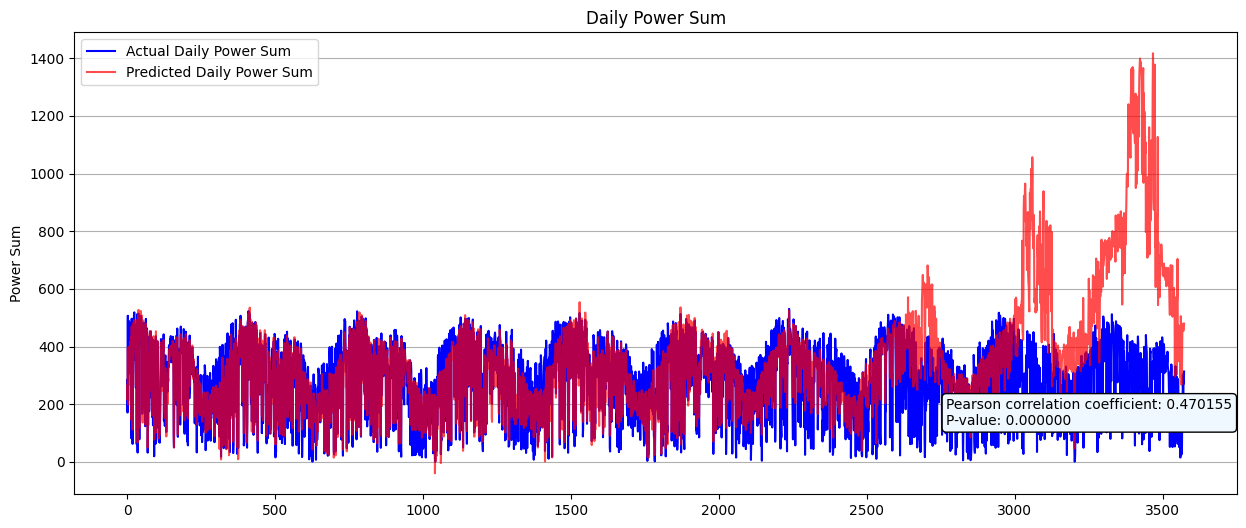

	Completed cbc model.
	Training and Predicting using ngb model...
[iter 0] loss=4.5861 val_loss=0.0000 scale=1.0000 norm=20.5148
[iter 100] loss=4.4715 val_loss=0.0000 scale=2.0000 norm=37.6216
[iter 200] loss=4.4353 val_loss=0.0000 scale=1.0000 norm=18.3118
[iter 300] loss=4.4182 val_loss=0.0000 scale=2.0000 norm=36.1160
[iter 400] loss=4.4056 val_loss=0.0000 scale=1.0000 norm=17.8721
mae : 11.03992947715424
RMSE : 13.918301564406901
Normalized RMSE : 0.19740449123389214
Error Percentage : 60.18558665697433


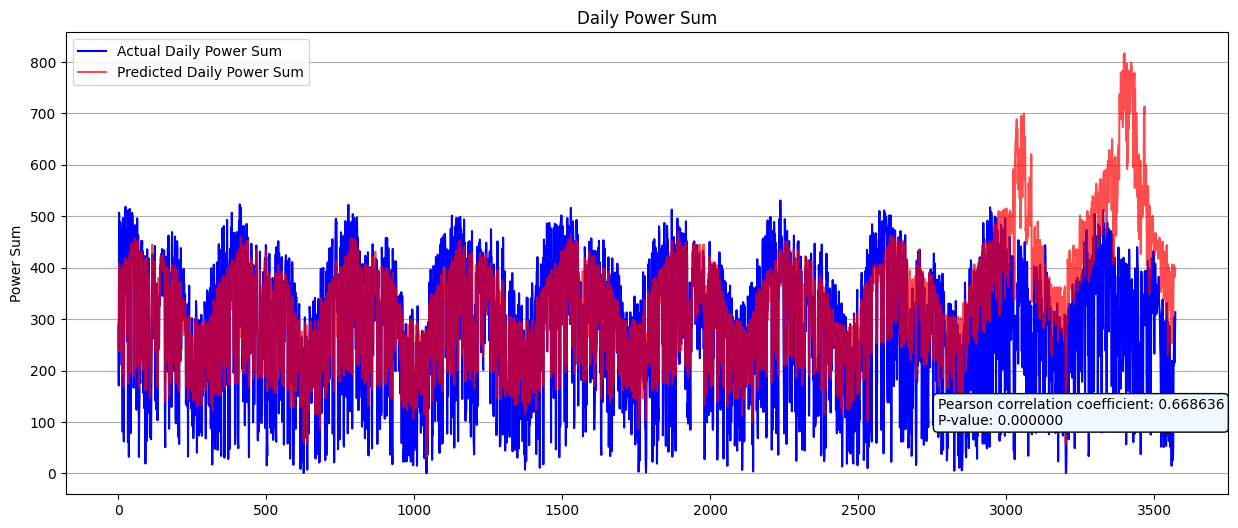

	Completed ngb model.
Completed testing for location 165.0.


Testing for location 112.0...


C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


	Training and Predicting using lgb model...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 154433, number of used features: 11
[LightGBM] [Info] Start training from score 26.144410
mae : 18.568689741712852
RMSE : 23.7322525122838
Normalized RMSE : 0.3363305337666788
Error Percentage : 89.47349896232727


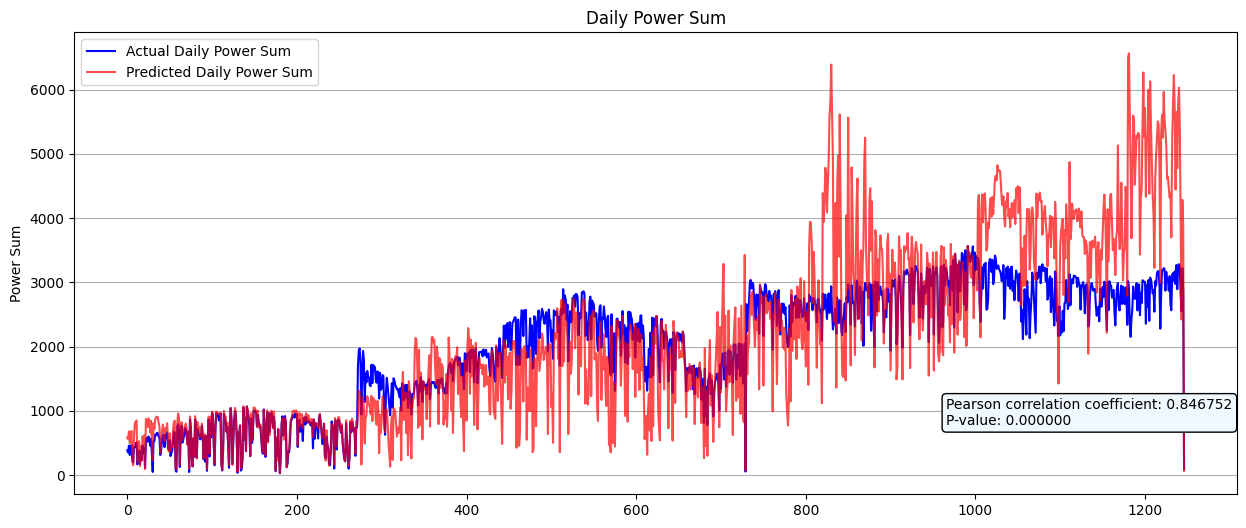

	Completed lgb model.
	Training and Predicting using xgb model...
mae : 19.277184685144384
RMSE : 24.79161890168341
Normalized RMSE : 0.35134374260628776
Error Percentage : 93.46744001337625


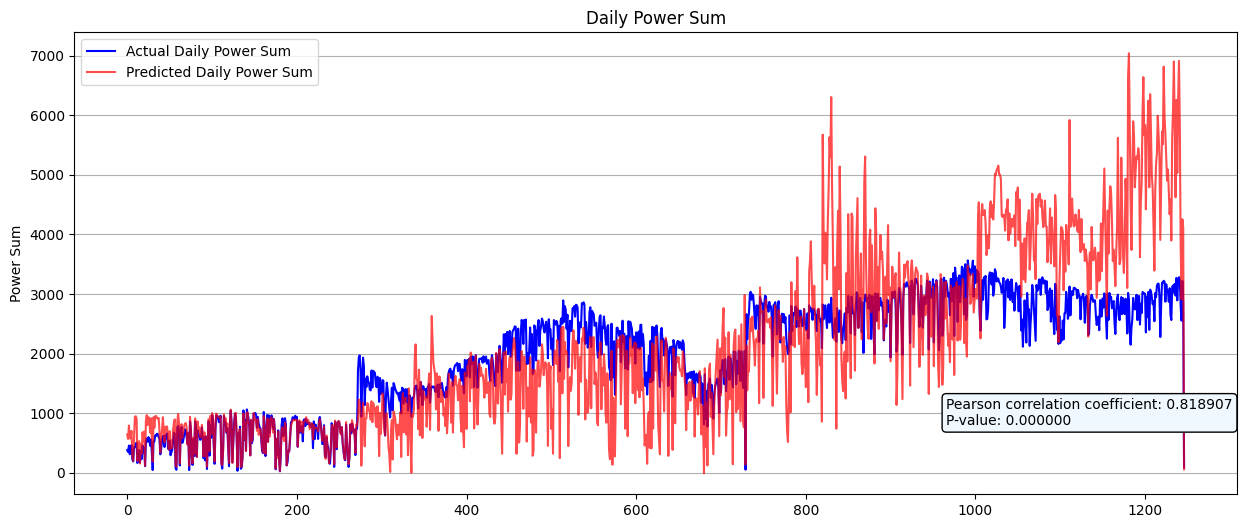

	Completed xgb model.
	Training and Predicting using ext model...
mae : 19.314292564005285
RMSE : 25.367286296136225
Normalized RMSE : 0.35950202939125153
Error Percentage : 95.6377766046273


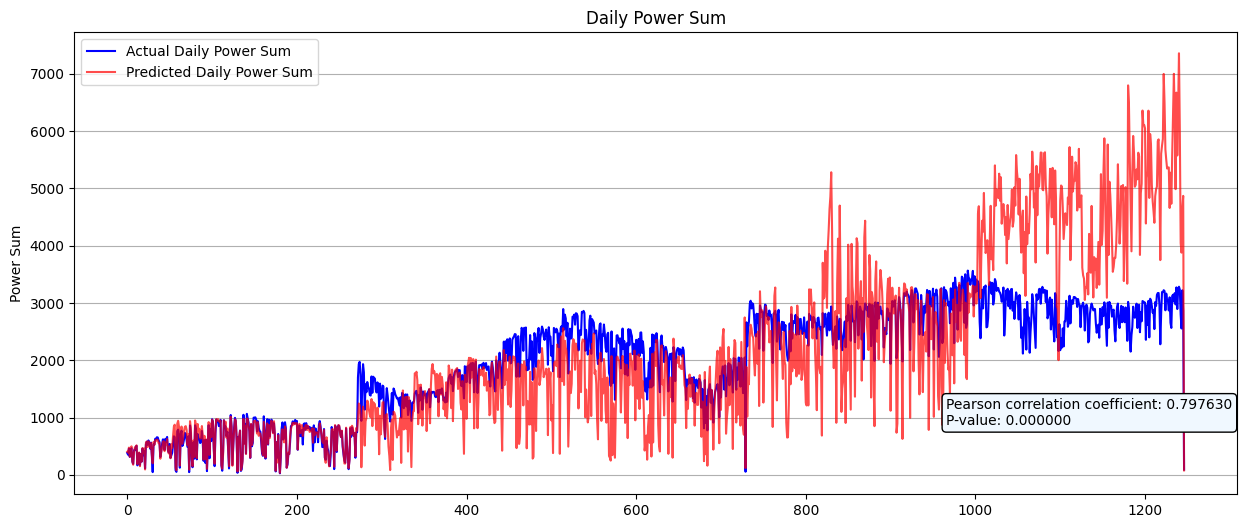

	Completed ext model.
	Training and Predicting using rf model...
mae : 19.367984290784957
RMSE : 25.441862990500763
Normalized RMSE : 0.3605589210373014
Error Percentage : 95.91893987736704


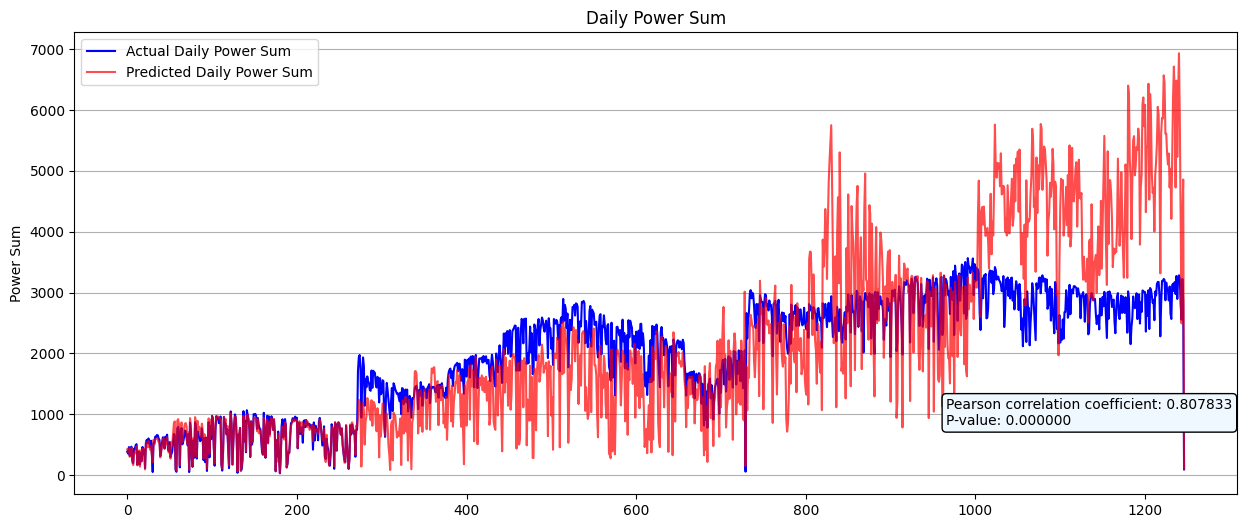

	Completed rf model.
	Training and Predicting using cbc model...
Learning rate set to 0.090782
0:	learn: 24.2617160	total: 16.1ms	remaining: 16.1s
1:	learn: 23.8112400	total: 29.9ms	remaining: 14.9s
2:	learn: 23.4265416	total: 43.5ms	remaining: 14.4s
3:	learn: 23.0933168	total: 58.5ms	remaining: 14.6s
4:	learn: 22.8055007	total: 70.1ms	remaining: 13.9s
5:	learn: 22.5671729	total: 82.2ms	remaining: 13.6s
6:	learn: 22.3467335	total: 94.6ms	remaining: 13.4s
7:	learn: 22.1511760	total: 107ms	remaining: 13.2s
8:	learn: 21.9855124	total: 119ms	remaining: 13.1s
9:	learn: 21.8585537	total: 131ms	remaining: 13s
10:	learn: 21.7302385	total: 142ms	remaining: 12.8s
11:	learn: 21.6189182	total: 155ms	remaining: 12.7s
12:	learn: 21.5127397	total: 167ms	remaining: 12.7s
13:	learn: 21.4260571	total: 180ms	remaining: 12.7s
14:	learn: 21.3242337	total: 192ms	remaining: 12.6s
15:	learn: 21.2582988	total: 203ms	remaining: 12.5s
16:	learn: 21.1815089	total: 215ms	remaining: 12.4s
17:	learn: 21.1189557	tota

160:	learn: 19.0621534	total: 1.93s	remaining: 10.1s
161:	learn: 19.0567250	total: 1.94s	remaining: 10.1s
162:	learn: 19.0518198	total: 1.96s	remaining: 10.1s
163:	learn: 19.0475513	total: 1.97s	remaining: 10s
164:	learn: 19.0449055	total: 1.98s	remaining: 10s
165:	learn: 19.0411471	total: 2s	remaining: 10s
166:	learn: 19.0345778	total: 2.01s	remaining: 10s
167:	learn: 19.0314517	total: 2.02s	remaining: 9.99s
168:	learn: 19.0279188	total: 2.03s	remaining: 9.98s
169:	learn: 19.0244683	total: 2.04s	remaining: 9.96s
170:	learn: 19.0199051	total: 2.05s	remaining: 9.95s
171:	learn: 19.0159705	total: 2.06s	remaining: 9.94s
172:	learn: 19.0114012	total: 2.08s	remaining: 9.93s
173:	learn: 19.0057508	total: 2.09s	remaining: 9.91s
174:	learn: 19.0005165	total: 2.1s	remaining: 9.91s
175:	learn: 18.9942977	total: 2.11s	remaining: 9.9s
176:	learn: 18.9901018	total: 2.12s	remaining: 9.88s
177:	learn: 18.9858231	total: 2.14s	remaining: 9.86s
178:	learn: 18.9814021	total: 2.15s	remaining: 9.86s
179:	l

317:	learn: 18.5095650	total: 3.83s	remaining: 8.22s
318:	learn: 18.5061363	total: 3.85s	remaining: 8.21s
319:	learn: 18.5046539	total: 3.86s	remaining: 8.2s
320:	learn: 18.5019602	total: 3.87s	remaining: 8.19s
321:	learn: 18.4983913	total: 3.88s	remaining: 8.18s
322:	learn: 18.4952829	total: 3.9s	remaining: 8.16s
323:	learn: 18.4934517	total: 3.91s	remaining: 8.15s
324:	learn: 18.4905695	total: 3.92s	remaining: 8.14s
325:	learn: 18.4894375	total: 3.93s	remaining: 8.13s
326:	learn: 18.4871183	total: 3.94s	remaining: 8.12s
327:	learn: 18.4829219	total: 3.96s	remaining: 8.11s
328:	learn: 18.4801447	total: 3.97s	remaining: 8.09s
329:	learn: 18.4773547	total: 3.98s	remaining: 8.08s
330:	learn: 18.4761829	total: 3.99s	remaining: 8.07s
331:	learn: 18.4738171	total: 4s	remaining: 8.06s
332:	learn: 18.4724292	total: 4.02s	remaining: 8.04s
333:	learn: 18.4708287	total: 4.03s	remaining: 8.03s
334:	learn: 18.4695866	total: 4.04s	remaining: 8.02s
335:	learn: 18.4679255	total: 4.05s	remaining: 8.01

473:	learn: 18.1727836	total: 5.76s	remaining: 6.39s
474:	learn: 18.1714657	total: 5.78s	remaining: 6.39s
475:	learn: 18.1686619	total: 5.79s	remaining: 6.38s
476:	learn: 18.1667199	total: 5.81s	remaining: 6.37s
477:	learn: 18.1663574	total: 5.82s	remaining: 6.36s
478:	learn: 18.1634393	total: 5.83s	remaining: 6.34s
479:	learn: 18.1625831	total: 5.85s	remaining: 6.33s
480:	learn: 18.1610454	total: 5.86s	remaining: 6.33s
481:	learn: 18.1598913	total: 5.87s	remaining: 6.31s
482:	learn: 18.1563705	total: 5.89s	remaining: 6.3s
483:	learn: 18.1549343	total: 5.9s	remaining: 6.29s
484:	learn: 18.1532435	total: 5.92s	remaining: 6.28s
485:	learn: 18.1499724	total: 5.93s	remaining: 6.27s
486:	learn: 18.1483670	total: 5.94s	remaining: 6.26s
487:	learn: 18.1469934	total: 5.96s	remaining: 6.25s
488:	learn: 18.1464865	total: 5.97s	remaining: 6.24s
489:	learn: 18.1438222	total: 5.99s	remaining: 6.23s
490:	learn: 18.1420680	total: 6s	remaining: 6.22s
491:	learn: 18.1402599	total: 6.01s	remaining: 6.21

641:	learn: 17.9161251	total: 8.1s	remaining: 4.51s
642:	learn: 17.9143464	total: 8.11s	remaining: 4.5s
643:	learn: 17.9120363	total: 8.13s	remaining: 4.49s
644:	learn: 17.9114872	total: 8.14s	remaining: 4.48s
645:	learn: 17.9100558	total: 8.15s	remaining: 4.47s
646:	learn: 17.9081316	total: 8.17s	remaining: 4.46s
647:	learn: 17.9068959	total: 8.18s	remaining: 4.44s
648:	learn: 17.9058172	total: 8.19s	remaining: 4.43s
649:	learn: 17.9042961	total: 8.21s	remaining: 4.42s
650:	learn: 17.9031209	total: 8.22s	remaining: 4.41s
651:	learn: 17.9026135	total: 8.23s	remaining: 4.39s
652:	learn: 17.9015214	total: 8.25s	remaining: 4.38s
653:	learn: 17.8999787	total: 8.26s	remaining: 4.37s
654:	learn: 17.8991528	total: 8.27s	remaining: 4.36s
655:	learn: 17.8979838	total: 8.29s	remaining: 4.34s
656:	learn: 17.8973122	total: 8.3s	remaining: 4.33s
657:	learn: 17.8961649	total: 8.31s	remaining: 4.32s
658:	learn: 17.8947684	total: 8.33s	remaining: 4.31s
659:	learn: 17.8935685	total: 8.34s	remaining: 4.

811:	learn: 17.7108315	total: 10.4s	remaining: 2.42s
812:	learn: 17.7099083	total: 10.5s	remaining: 2.4s
813:	learn: 17.7085052	total: 10.5s	remaining: 2.39s
814:	learn: 17.7068623	total: 10.5s	remaining: 2.38s
815:	learn: 17.7061296	total: 10.5s	remaining: 2.37s
816:	learn: 17.7050183	total: 10.5s	remaining: 2.35s
817:	learn: 17.7040154	total: 10.5s	remaining: 2.34s
818:	learn: 17.7026328	total: 10.5s	remaining: 2.33s
819:	learn: 17.7016000	total: 10.6s	remaining: 2.32s
820:	learn: 17.7001140	total: 10.6s	remaining: 2.3s
821:	learn: 17.6984938	total: 10.6s	remaining: 2.29s
822:	learn: 17.6978849	total: 10.6s	remaining: 2.28s
823:	learn: 17.6971973	total: 10.6s	remaining: 2.27s
824:	learn: 17.6964757	total: 10.6s	remaining: 2.25s
825:	learn: 17.6947774	total: 10.6s	remaining: 2.24s
826:	learn: 17.6941056	total: 10.7s	remaining: 2.23s
827:	learn: 17.6926741	total: 10.7s	remaining: 2.22s
828:	learn: 17.6913696	total: 10.7s	remaining: 2.2s
829:	learn: 17.6904311	total: 10.7s	remaining: 2.

978:	learn: 17.5367749	total: 12.8s	remaining: 274ms
979:	learn: 17.5362619	total: 12.8s	remaining: 261ms
980:	learn: 17.5348361	total: 12.8s	remaining: 248ms
981:	learn: 17.5339219	total: 12.8s	remaining: 235ms
982:	learn: 17.5330883	total: 12.8s	remaining: 222ms
983:	learn: 17.5319811	total: 12.8s	remaining: 209ms
984:	learn: 17.5305442	total: 12.9s	remaining: 196ms
985:	learn: 17.5298715	total: 12.9s	remaining: 183ms
986:	learn: 17.5289409	total: 12.9s	remaining: 170ms
987:	learn: 17.5281616	total: 12.9s	remaining: 157ms
988:	learn: 17.5277975	total: 12.9s	remaining: 144ms
989:	learn: 17.5263807	total: 12.9s	remaining: 130ms
990:	learn: 17.5249908	total: 12.9s	remaining: 117ms
991:	learn: 17.5238063	total: 12.9s	remaining: 104ms
992:	learn: 17.5230575	total: 13s	remaining: 91.4ms
993:	learn: 17.5227340	total: 13s	remaining: 78.3ms
994:	learn: 17.5222151	total: 13s	remaining: 65.3ms
995:	learn: 17.5214035	total: 13s	remaining: 52.2ms
996:	learn: 17.5200208	total: 13s	remaining: 39.2m

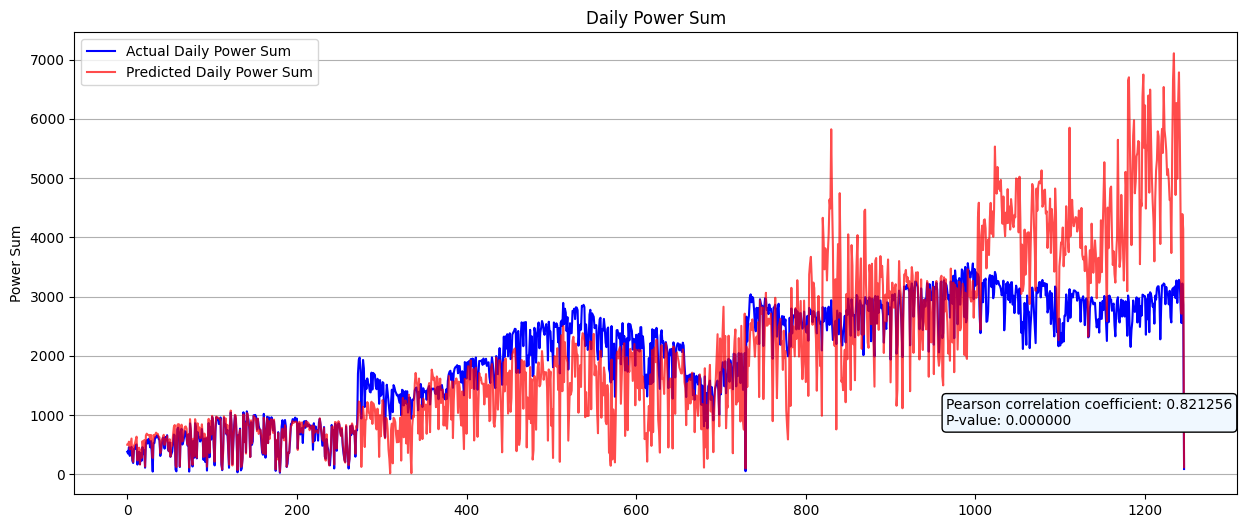

	Completed cbc model.
	Training and Predicting using ngb model...
[iter 0] loss=4.6290 val_loss=0.0000 scale=1.0000 norm=21.6060
[iter 100] loss=4.3689 val_loss=0.0000 scale=2.0000 norm=34.3498
[iter 200] loss=4.2393 val_loss=0.0000 scale=2.0000 norm=32.2801
[iter 300] loss=4.1853 val_loss=0.0000 scale=1.0000 norm=15.7791
[iter 400] loss=4.1606 val_loss=0.0000 scale=0.5000 norm=7.7926
mae : 17.30012611955055
RMSE : 21.48733178660825
Normalized RMSE : 0.30451579618374053
Error Percentage : 81.00987284359823


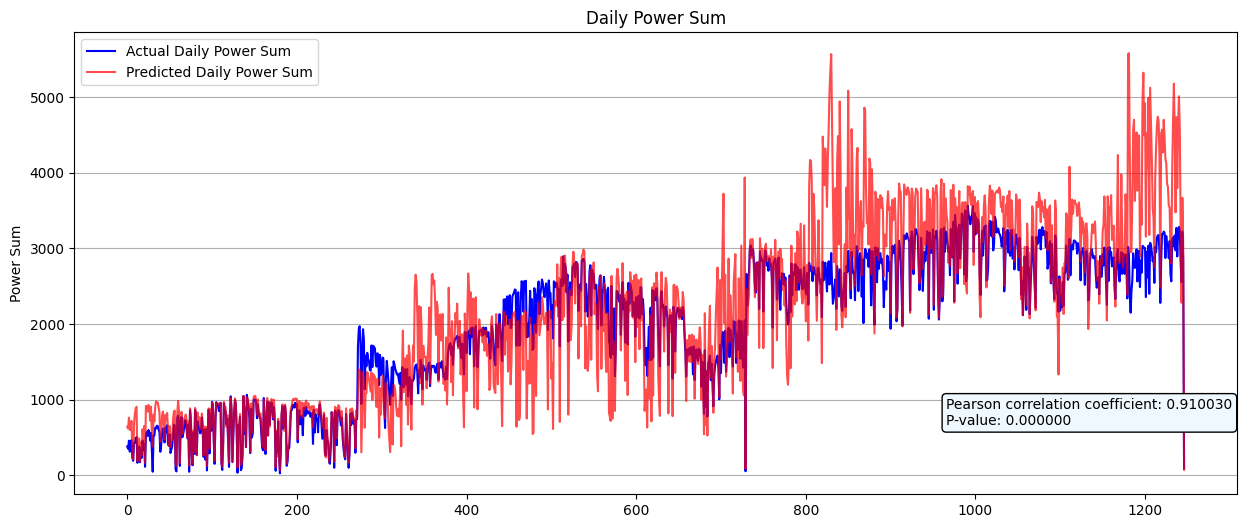

	Completed ngb model.
Completed testing for location 112.0.


Testing for location 140.0...


C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


	Training and Predicting using lgb model...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 212930, number of used features: 11
[LightGBM] [Info] Start training from score 27.500161
mae : 21.00177259490486
RMSE : 24.889929513579908
Normalized RMSE : 0.23674061860960544
Error Percentage : 132.10148428559972


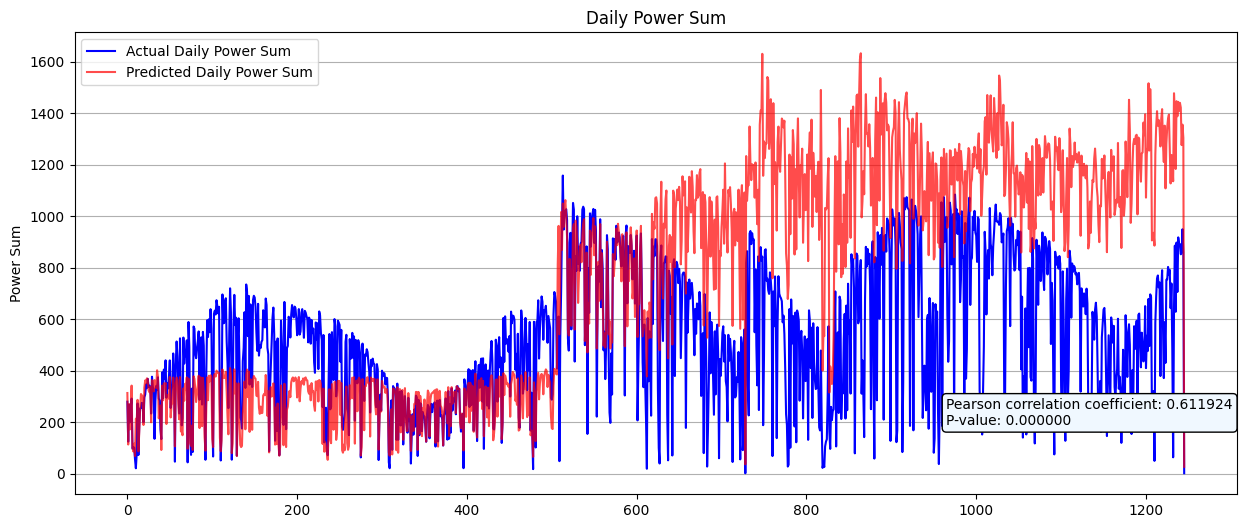

	Completed lgb model.
	Training and Predicting using xgb model...
mae : 21.20375589221285
RMSE : 25.600113616530138
Normalized RMSE : 0.24349553624677328
Error Percentage : 135.8707345787585


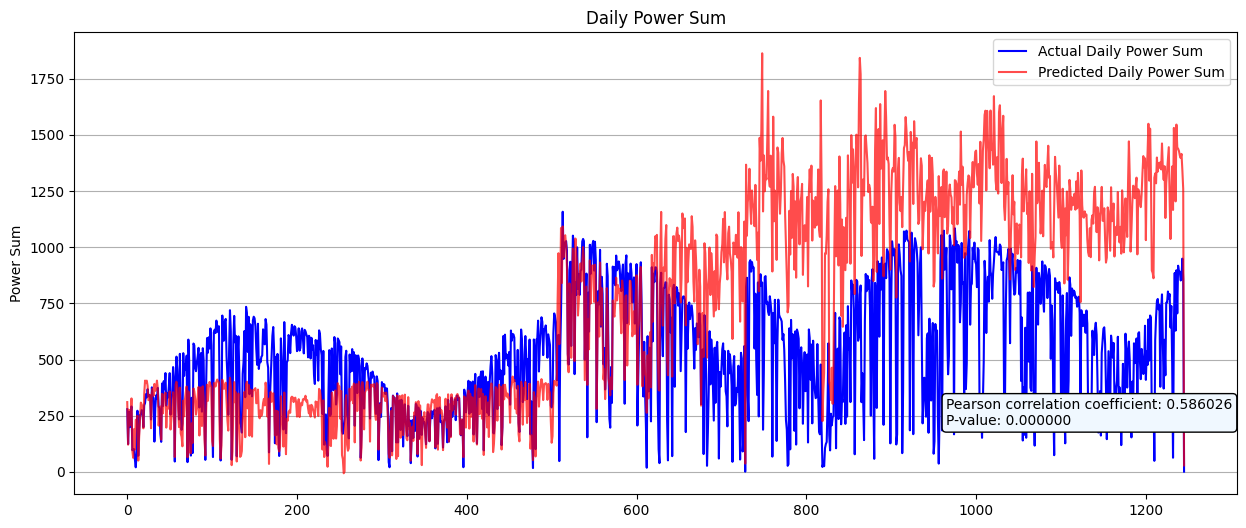

	Completed xgb model.
	Training and Predicting using ext model...


KeyboardInterrupt: 

In [14]:
#165.영암, 112.인천, 140.군산, 133.대전, 288.밀양, 239.세종, 119.수원, 260.장흥, 232.천안])
main(test_nums=[165., 112., 140., 133., 288., 239., 119., 260., 232.], model_choices=['lgb', 'xgb', 'ext', 'rf', 'cbc', 'ngb'])

# 밀양 test set (바다)

In [18]:
def preprocess_data_sea():
    
    train = pd.read_csv('train_without_chenan.csv', encoding='cp949')
    test = pd.read_csv('test_chenan.csv', encoding='cp949')
    all_data = pd.concat([train, test], ignore_index=True)

    all_data_train = all_data[all_data['location'] != 288.0] #밀양
    all_data_test = all_data[all_data['location'] == 288.0]



    all_data_train.fillna(-1, inplace=True)
    all_data_test.fillna(-1, inplace=True)

    all_data = pd.concat([all_data_train, all_data_test], ignore_index=True)

    all_data['date'] = pd.to_datetime(all_data['date'])

    # 연도, 월, 시간 추출하여 새로운 열로 추가
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['hour'] = all_data['date'].dt.hour

    # date	name	asos_num	power/land	location	Temp(C)	Prec(mm)	
    # Wind_speed(m/s)	Dew_Point(C)	sunshine(hr)	Solar_Radiation(MJ/m2)	Snowfall(cm)	Cloud_Cover(1/10)

    drop_columns = ["date", "asos_num", "location", "name", "power/land"]

    all_data = all_data.drop(columns=drop_columns)

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
    num_train = len(all_data_train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = all_data_train['power/land'].values
    y_test = all_data_test['power/land'].values
    return X, y, X_test, y_test

X, y, X_test, y_test = preprocess_data_sea()
ET_regressor = ExtraTreesRegressor()
ET_regressor.fit(X, y)
Regressor_pred = ET_regressor.predict(X_test)
test_rmse(y_test, Regressor_pred)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\2752769487.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\2752769487.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 13.950510319258242
RMSE : 19.045154830876392
Normalized RMSE : 0.28721785459232285
Error Percentage : 0.0004639506188265034


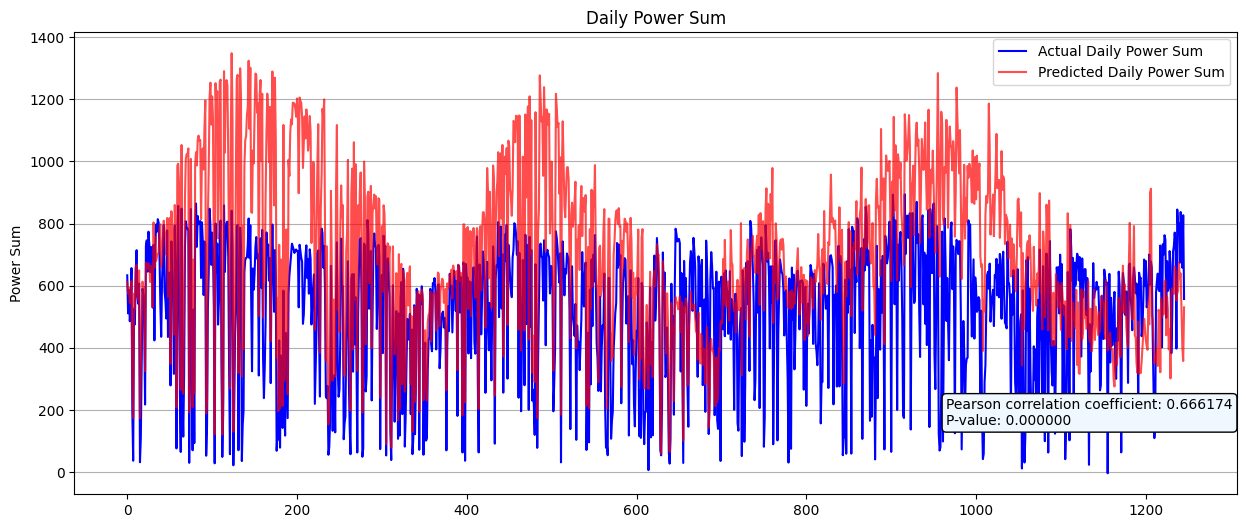

In [19]:
train = pd.read_csv('train_without_chenan.csv', encoding='cp949')
test = pd.read_csv('test_chenan.csv', encoding='cp949')
all_data = pd.concat([train, test], ignore_index=True)

all_data_train = all_data[all_data['location'] != 288.0] #밀양
all_data_test = all_data[all_data['location'] == 288.0]
 
daily_visualize(y_test, Regressor_pred, all_data_test)

In [20]:
X, y, X_test, y_test = preprocess_data()
rf_run = RandomForestRegressor()
rf_run.fit(X, y)
Regressor_pred_rf = rf_run.predict(X_test)
test_rmse(y_test, Regressor_pred_rf)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 46.475991836553284
RMSE : 49.18015786802407
Normalized RMSE : 0.6508062087084536
Error Percentage : 0.001198056139709783


In [21]:
daily_visualize(y_test, Regressor_pred_rf, all_data_test)

ValueError: Shape of passed values is (13258, 1), indices imply (29449, 1)

# 천안 test set

In [14]:
X, y, X_test, y_test = preprocess_data()
ET_regressor = ExtraTreesRegressor()
ET_regressor.fit(X, y)
Regressor_pred = ET_regressor.predict(X_test)
test_rmse(y_test, Regressor_pred)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 46.833640226026816
RMSE : 49.61279971351803
Normalized RMSE : 0.656531403815597
Error Percentage : 0.0012085955369333617


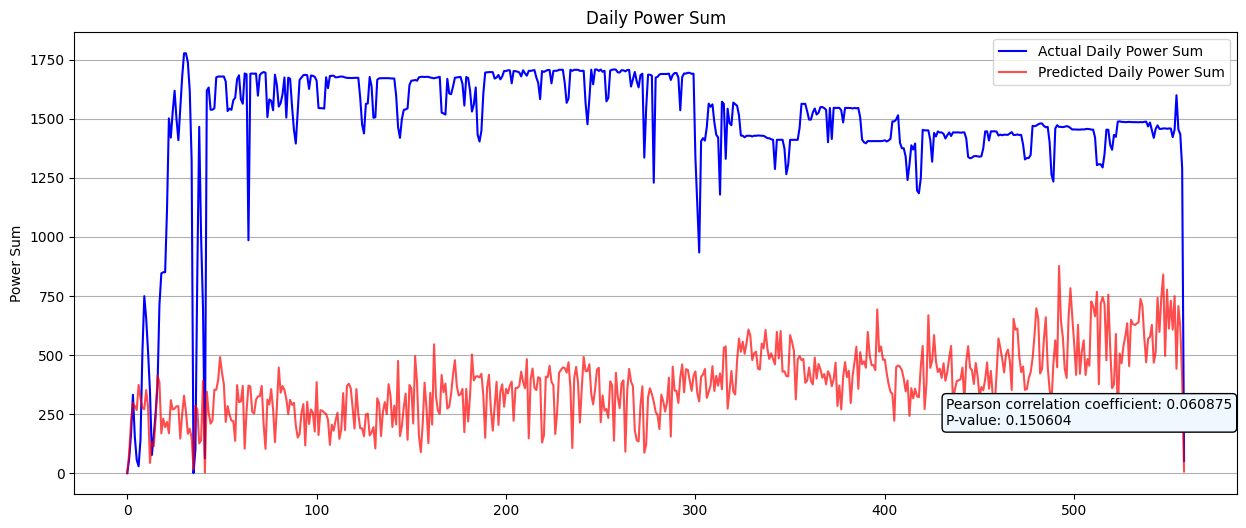

In [15]:
test = pd.read_csv('test_chenan.csv', encoding = 'cp949')
daily_visualize(y_test, Regressor_pred, test)

In [16]:
X, y, X_test, y_test = preprocess_data()
rf_run = RandomForestRegressor()
rf_run.fit(X, y)
Regressor_pred_rf = rf_run.predict(X_test)
test_rmse(y_test, Regressor_pred_rf)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 46.47126686304085
RMSE : 49.17320627625533
Normalized RMSE : 0.6507142175624381
Error Percentage : 0.0011978867950480265


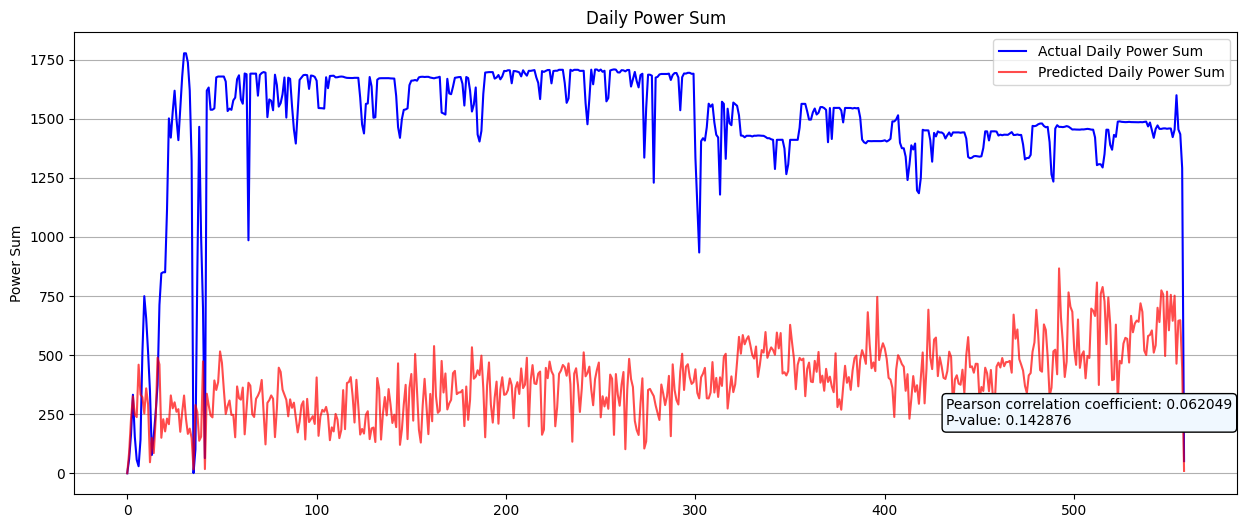

In [17]:
test = pd.read_csv('test_chenan.csv', encoding = 'cp949')
daily_visualize(y_test, Regressor_pred_rf, test)

# 영암 F1 데이터만 사용

In [15]:
X, y, X_test, y_test = preprocess_data()
ET_regressor = ExtraTreesRegressor()
ET_regressor.fit(X, y)
Regressor_pred = ET_regressor.predict(X_test)
test_rmse(y_test, Regressor_pred)

mae : 720.913924334005
RMSE : 4536.5111424703655
Normalized RMSE : 0.0003735598766856362
Error Percentage : 0.11051194755582895


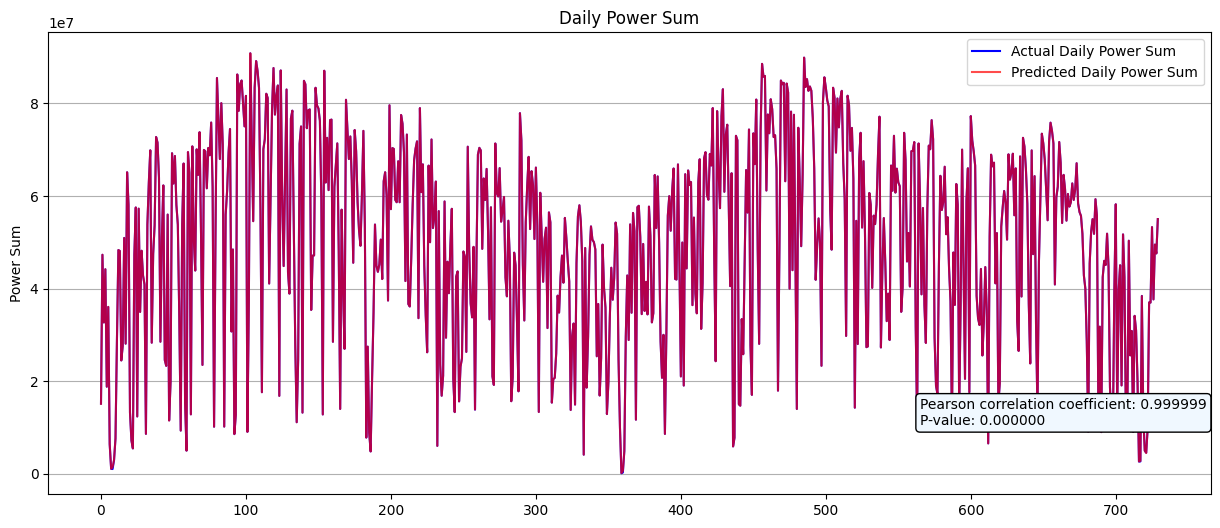

In [17]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred, test.index)

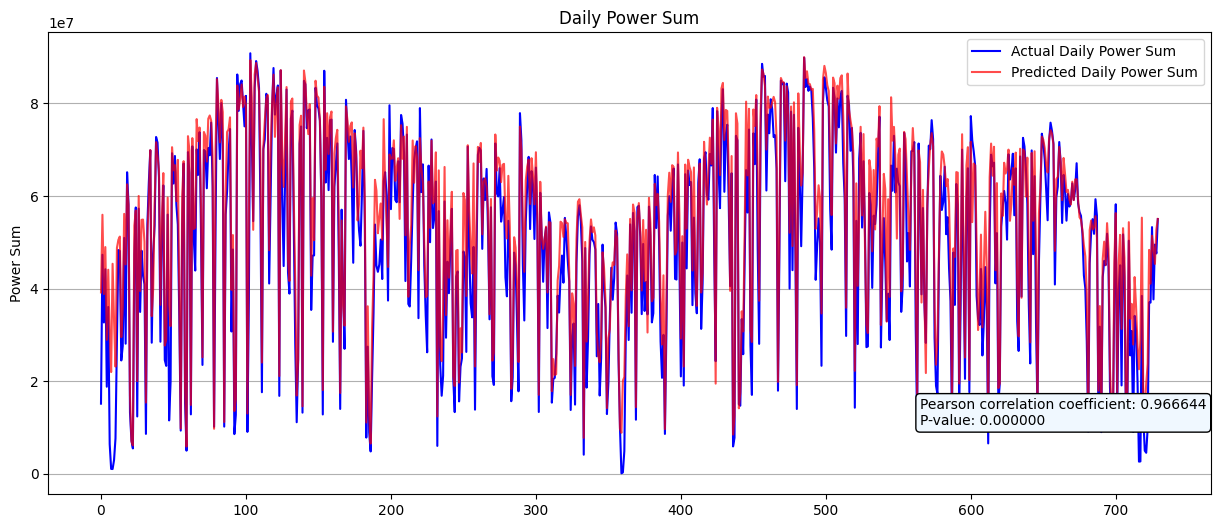

In [12]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred, test.index)

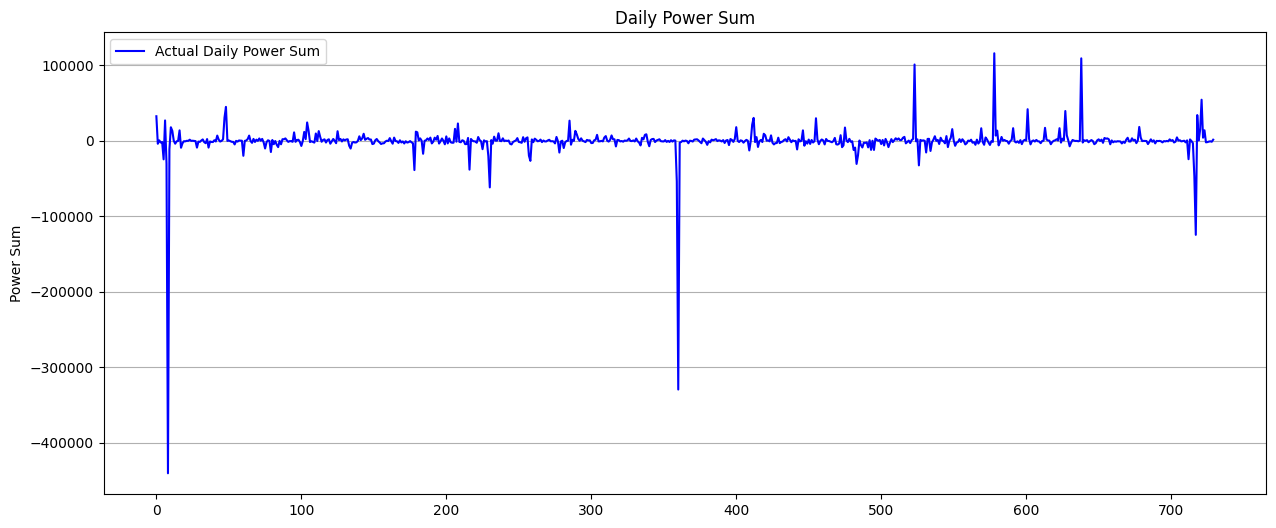

In [18]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

plt.figure(figsize=(15, 6))
plt.plot(daily_actual_sum - daily_predicted_sum, label='Actual Daily Power Sum', color='blue')
plt.title('Daily Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()

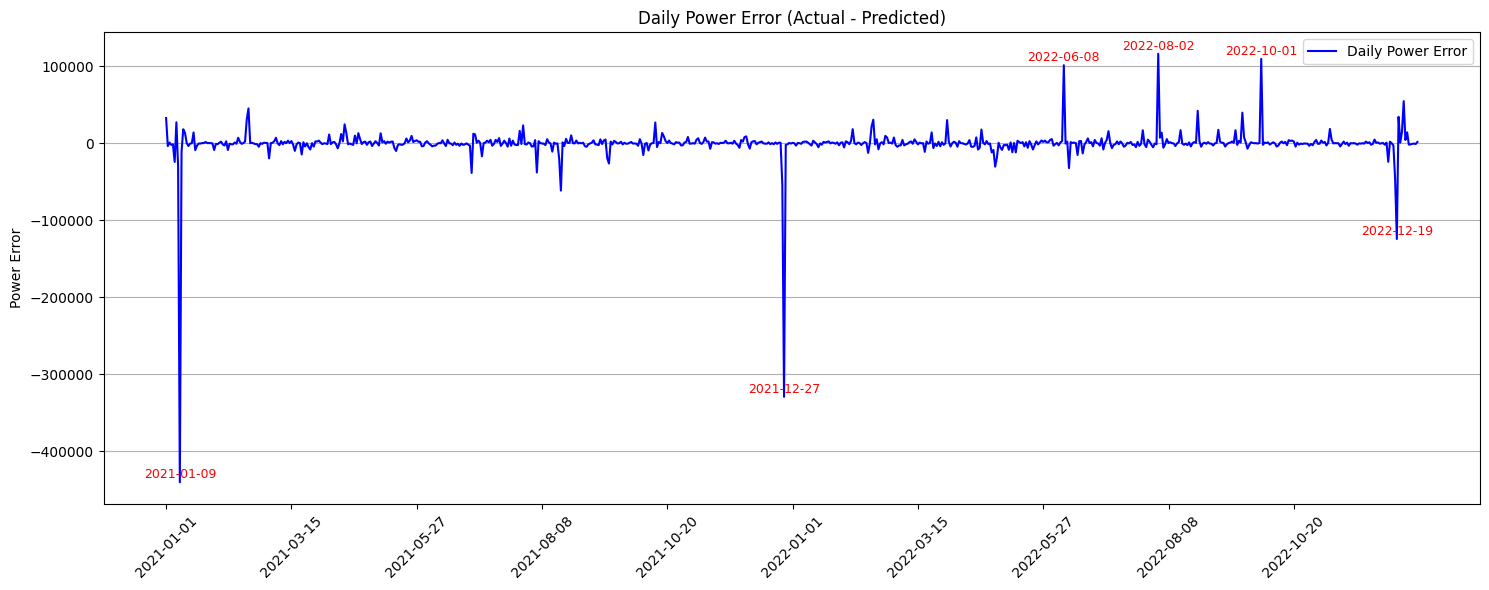

In [20]:

test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 20개의 오차를 가진 날짜 선택
top_20_error_dates = sorted_error_df.head(6)

top_20_absolute_error_dates = error_df.iloc[np.argsort(-np.abs(error_df['error'].values))[:6]]


# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(error, label='Daily Power Error', color='blue')
plt.title('Daily Power Error (Actual - Predicted)')
plt.ylabel('Power Error')
plt.legend()
plt.grid(True, axis='y')

# x축에 날짜 정보 설정
dates = np.unique(y_test_df.index.date)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/10)), labels=[dates[i].strftime('%Y-%m-%d') for i in range(0, len(dates), int(len(dates)/10))], rotation=45)

# 상위 20개 오차를 그래프에 주석으로 추가
for idx, row in top_20_absolute_error_dates.iterrows():
    date = row['date']
    err = row['error']
    date_idx = list(dates).index(date)
    plt.annotate(f"{date.strftime('%Y-%m-%d')}", (date_idx, err), 
                 textcoords="offset points", xytext=(0,3), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

In [22]:
X, y, X_test, y_test = preprocess_data()
rf_run = RandomForestRegressor()
rf_run.fit(X, y)
Regressor_pred_rf = rf_run.predict(X_test)
test_rmse(y_test, Regressor_pred_rf)

mae : 18.917170360420865
RMSE : 390.7504595616469
Normalized RMSE : 3.217642124190109e-05
Error Percentage : 0.009518899642992526


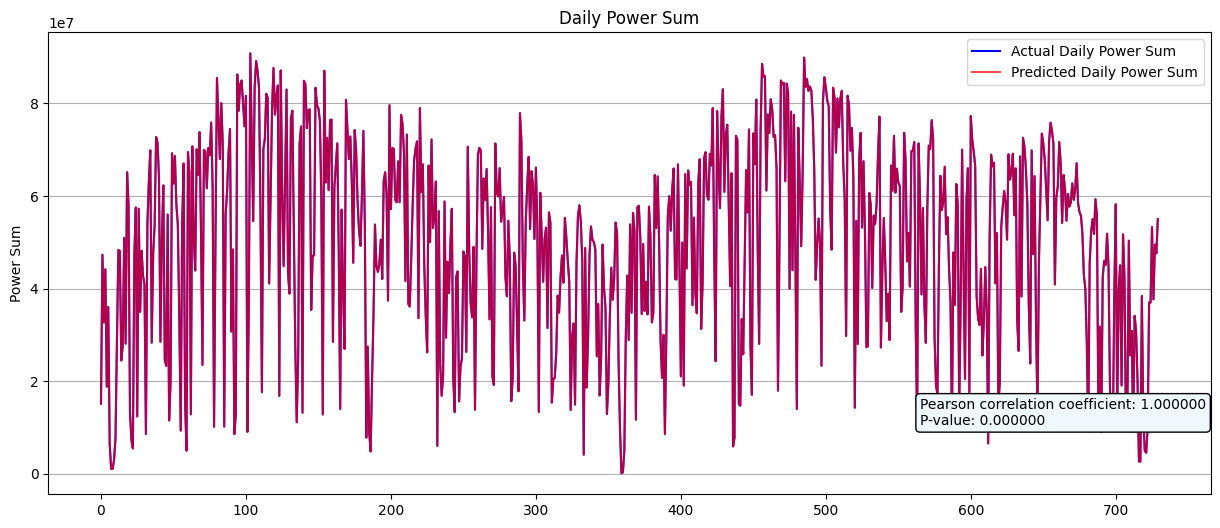

In [24]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred_rf, test.index)

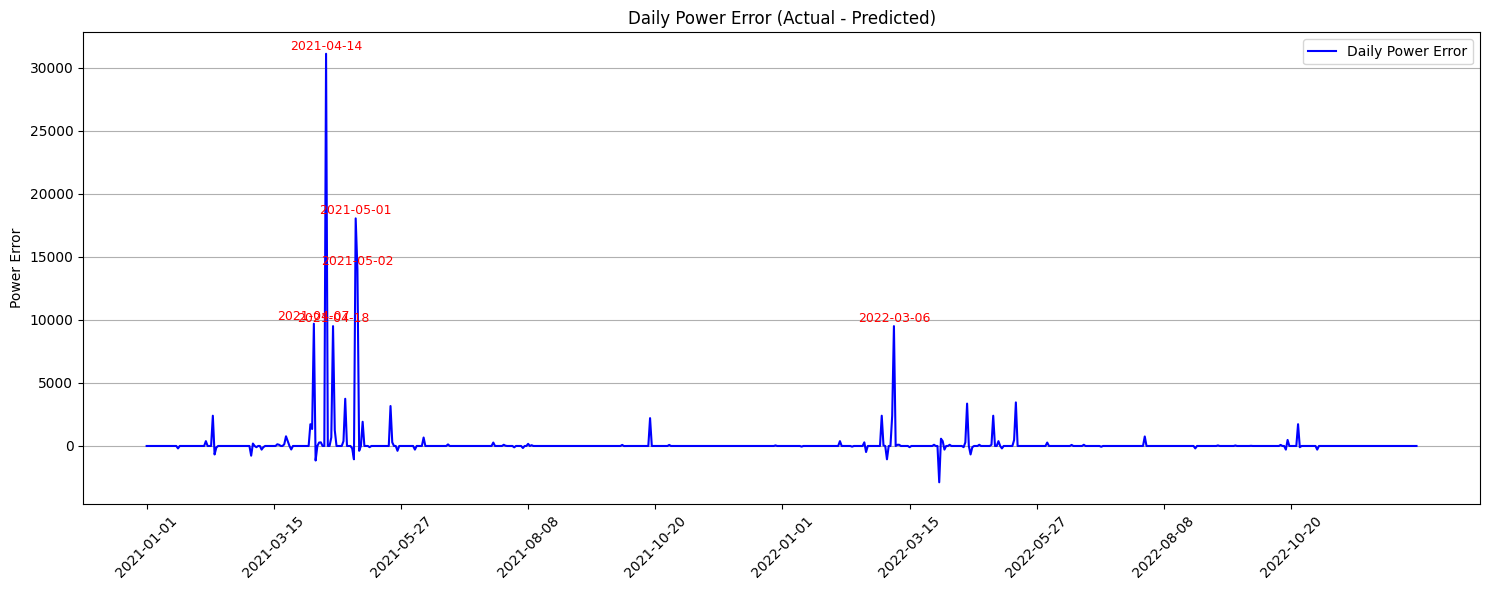

In [25]:

test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred_rf[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 20개의 오차를 가진 날짜 선택
top_20_error_dates = sorted_error_df.head(6)

top_20_absolute_error_dates = error_df.iloc[np.argsort(-np.abs(error_df['error'].values))[:6]]


# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(error, label='Daily Power Error', color='blue')
plt.title('Daily Power Error (Actual - Predicted)')
plt.ylabel('Power Error')
plt.legend()
plt.grid(True, axis='y')

# x축에 날짜 정보 설정
dates = np.unique(y_test_df.index.date)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/10)), labels=[dates[i].strftime('%Y-%m-%d') for i in range(0, len(dates), int(len(dates)/10))], rotation=45)

# 상위 20개 오차를 그래프에 주석으로 추가
for idx, row in top_20_absolute_error_dates.iterrows():
    date = row['date']
    err = row['error']
    date_idx = list(dates).index(date)
    plt.annotate(f"{date.strftime('%Y-%m-%d')}", (date_idx, err), 
                 textcoords="offset points", xytext=(0,3), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

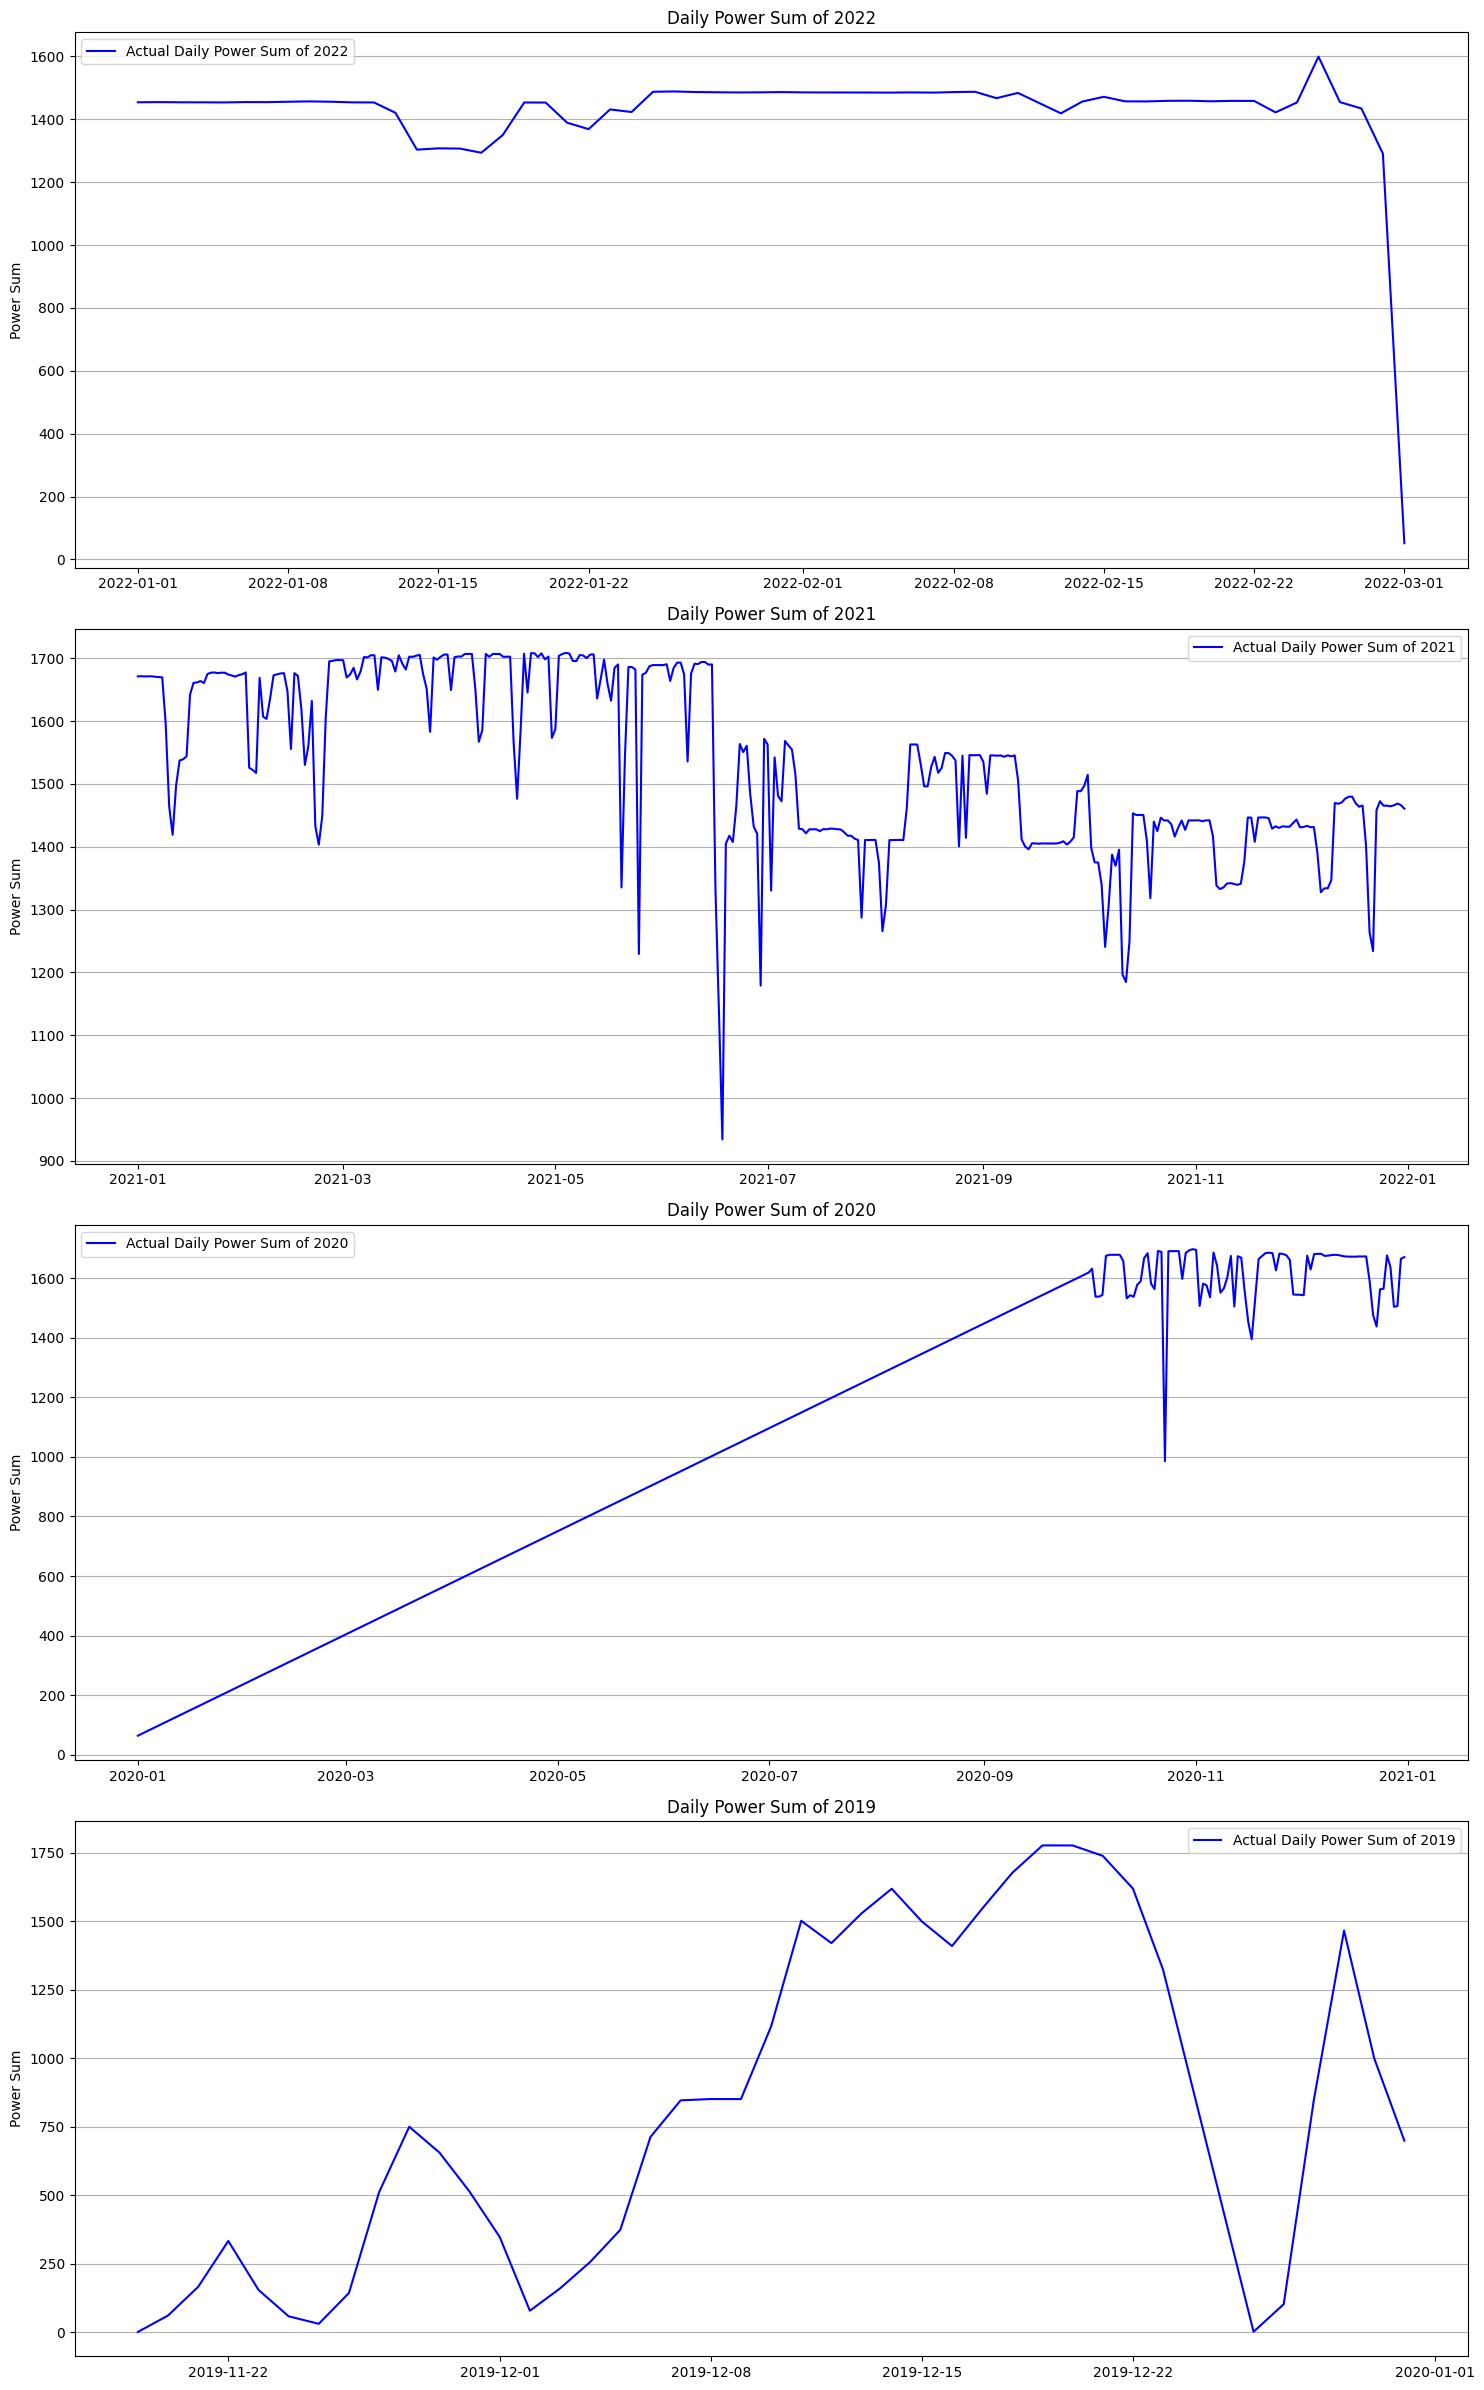

In [4]:
train = pd.read_csv('train_without_chenan.csv', encoding='cp949')
test = pd.read_csv('test_chenan.csv', encoding='cp949')
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)
all_data = pd.concat([train, test], ignore_index=True)

all_data['date'] = pd.to_datetime(all_data['date'])

# 연도, 월, 시간 추출하여 새로운 열로 추가
all_data['year'] = all_data['date'].dt.year
all_data['month'] = all_data['date'].dt.month
all_data['hour'] = all_data['date'].dt.hour


drop_columns = ["date", "asos_num", "location", "name"]

all_data = all_data.drop(columns=drop_columns)

all_data.head()
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
num_train = len(train)
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]
y = train['power/land'].values
y_test = test['power/land'].values

# 'date' 칼럼을 datetime 형식으로 변환하고 인덱스로 설정
y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test['date']), columns=['power/land'])

unique_years = y_test_df.index.year.unique()

plt.figure(figsize=(15, 6 * len(unique_years)))

for idx, year in enumerate(unique_years):
    yearly_data = y_test_df[y_test_df.index.year == year]
    
    # 일자별로 그룹화하고 합계를 계산
    daily_actual_sum = yearly_data.groupby(yearly_data.index.date)['power/land'].sum()
    
    plt.subplot(len(unique_years), 1, idx+1)
    plt.plot(daily_actual_sum, label=f'Actual Daily Power Sum of {year}', color='blue')
    plt.title(f'Daily Power Sum of {year}')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
all_data = pd.read_csv('asos_train.csv', encoding='cp949')
all_data.head()

power                 date       name  capacities  asos_num      land   
0  1296000.0  2022-12-31 09:00:00  영암에프원태양광b      13.296     165.0  175507.2  \
1  4377600.0  2022-12-31 10:00:00  영암에프원태양광b      13.296     165.0  175507.2   
2  7065600.0  2022-12-31 11:00:00  영암에프원태양광b      13.296     165.0  175507.2   
3  8860800.0  2022-12-31 12:00:00  영암에프원태양광b      13.296     165.0  175507.2   
4  7891200.0  2022-12-31 13:00:00  영암에프원태양광b      13.296     165.0  175507.2   

   power/land  location            Date/Time  Temp(C)  Prec(mm)   
0    7.384312     165.0  2022-12-31 09:00:00      0.1       NaN  \
1   24.942566     165.0  2022-12-31 10:00:00      1.7       NaN   
2   40.258177     165.0  2022-12-31 11:00:00      2.8       NaN   
3   50.486818     165.0  2022-12-31 12:00:00      4.1       NaN   
4   44.962258     165.0  2022-12-31 13:00:00      4.2       NaN   

   Wind_speed(m/s)  Wind_Direction(16 compass points)  Humidity   
0              0.9                               70.0      85.0  \
1              0.4                                0.0      75.0   
2              2.4                               50.0      64.0   
3              3.8                              360.0      61.0   
4              5.4                              340.0      57.0   

   Vapor_pressure(hPa)  Dew_Point(C)  Local Atmospheric Pressure(hPa)   
0                  5.2          -2.1                           1027.7  \
1                  5.2          -2.2                           1028.0   
2                  4.8          -3.3                           1027.7   
3                  5.0          -2.7                           1027.0   
4                  4.7          -3.5                           1026.2   

   Sea-level_Pressure(hPa)  sunshine(hr)  Solar_Radiation(MJ/m2)   
0                   1033.4           0.7                    0.37  \
1                   1033.7           1.0                    1.04   
2                   1033.4           1.0                    1.54   
3                   1032.6           1.0                    1.86   
4                   1031.8           0.6                    1.53   

   Snowfall(cm)  3-hour_Fresh_Snowfall  Cloud_Cover(1/10)   
0           NaN                    NaN                0.0  \
1           NaN                    NaN                0.0   
2           NaN                    NaN                0.0   
3           NaN                    NaN                0.0   
4           NaN                    NaN                4.0   

   Mid-Low_Cloud_Cover Cloud_Form  Lowest_Cloud_Height(100m)  Visibility(10m)   
0                  0.0        NaN                        NaN           1295.0  \
1                  0.0        NaN                        NaN           1534.0   
2                  0.0        NaN                        NaN           2617.0   
3                  0.0        NaN                        NaN           2779.0   
4                  4.0         Sc                       10.0           3442.0   

   Ground_Condition  Phenomenon_Number  Ground Temp  5cm_Underground_Temp   
0               NaN                NaN         -0.5                   2.5  \
1               NaN                NaN          0.0                   2.9   
2               NaN                NaN          3.8                   3.7   
3               NaN                NaN         10.3                   4.4   
4               NaN                NaN          6.1                   4.7   

   10cm_Underground_Temp  20cm_Underground_Temp  30cm_Underground_Temp  
0                    3.3                    4.2                    4.7  
1                    3.4                    4.2                    4.8  
2                    3.7                    4.2                    4.8  
3                    3.9                    4.2                    4.8  
4                    4.3                    4.3                    4.7

In [9]:
all_data['location'].unique()

array([165., 112., 140., 133., 288., 239., 119., 260., 232.])

In [11]:
X_test.shape

(29449, 12)